In [1]:
from pymongo import MongoClient
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib_venn as venn3
from math import *
import os
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Descriptors

#
import itertools

cannot import venn diagram modul from matplotlib
/Users/jonas/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages

In [2]:
%matplotlib inline

**Complete Databank**

In [3]:
client = MongoClient("localhost:27017")
db_complete = client['COCONUT2020-10']

In [4]:
collection = db_complete.uniqueNaturalProduct
db_complete_only_ring_sugars = pd.DataFrame(list(collection.find({"contains_ring_sugars": True})))

In [5]:
all_tax_df = pd.DataFrame({"taxonomy": db_complete_only_ring_sugars["textTaxa"],
                       "smiles": db_complete_only_ring_sugars["smiles"],
                       "coconut_id": db_complete_only_ring_sugars["coconut_id"],
                       "no_sugar_smiles": db_complete_only_ring_sugars["sugar_free_smiles"]
                      })

In [10]:
#display(all_tax_df)

In [11]:
all_names = []
indexes = []
for i in range(len(all_tax_df.taxonomy)):
    # some entries are empty lists
    if all_tax_df.taxonomy[i] == []:
        pass
    # doubles
    elif "plants" in all_tax_df.taxonomy[i] or "bacteria" in all_tax_df.taxonomy[i] or "marine" in all_tax_df.taxonomy[i] or "animals" in all_tax_df.taxonomy[i] or "fungi" in all_tax_df.taxonomy[i]:
        indexes.append(i)
        all_names.append(all_tax_df.taxonomy[i])
        
        
    

In [12]:
five_tax_df = all_tax_df.loc[indexes[:]]

In [13]:
#five_tax_df

In [14]:
five_tax_and_id_df = pd.DataFrame({"taxonomy": five_tax_df.taxonomy,
                                   "coconut_id": five_tax_df.coconut_id})

In [15]:
needless_names = []
for row in five_tax_and_id_df.taxonomy:
    for name in row:
        if name == "plants":
            pass
        elif name == "bacteria":
            pass
        elif name == "fungi":
            pass
        elif name == "marine":
            pass
        elif name == "animals":
            pass
        else:
            needless_names.append(name)

In [20]:
for needless_name in needless_names:
    for row in five_tax_and_id_df.taxonomy:
        if needless_name in row:
            row.remove(needless_name)
            
            

In [21]:
#count2_plants = 0
#count2_animals = 0
#count2_bacteria = 0
#count2_marine = 0
#count2_fungi = 0

In [22]:
#for test_if_all_there in five_tax_and_id_df.taxonomy:
#        if "plants" in unique_tax:
#            count2_plants += 1
#        if "bacteria" in unique_tax:
#            count2_bacteria += 1
#        if "marine" in unique_tax:
#            count2_marine += 1
#        if "animals" in unique_tax:
#            count2_animals += 1
#        if "fungi" in unique_tax:
#            count2_fungi += 1
        

In [23]:
#comparing2 = {"plants":count_plants,"animals":count_animals,"bacteria":count_bacteria,"fungi":count_fungi,"marine":count_marine}

In [24]:
#comparing2

**Sweetcoconut Databank**

In [25]:
client2 = MongoClient("localhost:27017")
db_s = client2["sweetcoconut"]
collection2 = db_s.sweetNaturalProduct
sweetnp = pd.DataFrame(list(collection2.find({"contains_sugar": True})))

In [26]:
sweetnp_with_plants_tax_nan = pd.merge(sweetnp, five_tax_and_id_df, how="left", on="coconut_id")

In [27]:
same_aglycon = pd.DataFrame({"coconut_id": sweetnp_with_plants_tax_nan.coconut_id,
                             "taxonomy": sweetnp_with_plants_tax_nan.taxonomy,
                             "all_deglycosilated_smiles": sweetnp_with_plants_tax_nan.all_deglycosilated_smiles
})

In [28]:
#display(same_aglycon)

In [29]:
same_aglycon_explode = same_aglycon.explode("all_deglycosilated_smiles",ignore_index=True)

In [30]:
#display(same_aglycon_explode)

In [31]:
all_deglycosilated_smiles_list = set(same_aglycon_explode["all_deglycosilated_smiles"])

In [32]:
new_df = pd.DataFrame(all_deglycosilated_smiles_list, columns=["deglycosilated_smiles"])

In [33]:
new_df["coconut_id"] = ""
new_df["taxonomy"] = ""

In [34]:
index = 1
for mol in new_df.deglycosilated_smiles:
    all_rows = same_aglycon_explode[same_aglycon_explode["all_deglycosilated_smiles"]==mol]
    new_df.coconut_id[index] = (all_rows.coconut_id.values)
    new_df.taxonomy[index] = (all_rows.taxonomy.values)
    index += 1

In [35]:
display(new_df)

,deglycosilated_smiles,coconut_id,taxonomy
0,,,
1,OC(=NC)C(N)C(C)CC,"[CNP0189711, CNP0162972, CNP0272903, CNP032810...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,O=C1C=2C=CC=CC2C(=O)C=3C1=C(O)C(O)=C(C3CC4(C=5...,"[CNP0403561, CNP0403561]","[nan, nan]"
3,O=C1C=2C=CC=CC2C(=O)C=3C(O)=C(C(=CC13)CO)CO,[CNP0422346],[nan]
4,O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=CC3,[CNP0196850],[nan]
...,...,...,...
21176,O=C1OC2CC3(OC(CC(O)CC)C(C)CC3)OC(CC4(O)OCC(C)C...,"[CNP0418838, CNP0095547, CNP0023486, CNP0095088]","[nan, [plants], nan, [plants]]"
21177,O=C(OC1CC2N(C)C(CC2)C1)C=3C=C(C(O)=C(C3)CC=C(C...,[CNP0392685],[nan]
21178,O=C1OC(C2=COC=C2)CC3(C)C4CC=CC5(O)COC(C(O)C13O...,[CNP0314575],[nan]
21179,OC(C(=C)C)CCC(O)(C)C1CCC2(C)C1C(O)CC3C4(C)CC(O...,[CNP0358988],[nan]


In [36]:
count_plants = 0
count_animals = 0
count_bacteria = 0
count_marine = 0
count_fungi = 0

In [37]:
for all_tax in new_df.taxonomy:
    for lists in all_tax:
        if type(lists) == list:
            for unique_tax in lists:
                if "plants" in unique_tax:
                    count_plants += 1
                if "bacteria" in unique_tax:
                    count_bacteria += 1
                if "marine" in unique_tax:
                    count_marine += 1
                if "animals" in unique_tax:
                    count_animals += 1
                if "fungi" in unique_tax:
                    count_fungi += 1
        else:
            pass
    

In [38]:
comparing = {"plants":count_plants,"animals":count_animals,"bacteria":count_bacteria,"fungi":count_fungi,"marine":count_marine}

In [39]:
comparing

{'plants': 9211, 'animals': 102, 'bacteria': 1308, 'fungi': 284, 'marine': 373}

<BarContainer object of 5 artists>

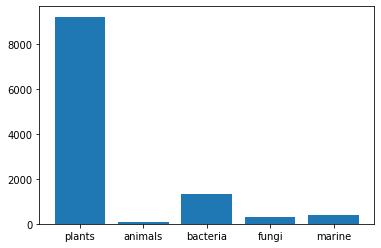

In [40]:
plt.bar(comparing.keys(),comparing.values())

**----------------------------------------------------------------**

**Seperate aglycons with at least to different entries in taxonomy**

In [41]:
indexes_only_double = []
indexes_without_double = []
counter = 0
for tax_double_list in new_df.taxonomy:
        for tax_list in tax_double_list:
            if type(tax_list) == list:
                if len(tax_list) > 1:
                    #print(counter, tax_list, len(tax_list))
                    indexes_only_double.append(counter)
                else:
                    #print(counter, tax_list, len(tax_list))
                    indexes_without_double.append(counter)
            else:
                indexes_without_double.append(counter)
        counter +=1 

In [42]:
same_aglycon_without_doubles_indexes = set(indexes_without_double)
same_aglycon_with_doubles_indexes = set(indexes_only_double)
same_aglycon_without_doubles_indexes = same_aglycon_without_doubles_indexes - same_aglycon_with_doubles_indexes

In [43]:
same_aglycon_with_doubles = pd.DataFrame(columns=["deglycosilated_smiles","coconut_id","taxonomy"])
for index in same_aglycon_with_doubles_indexes:
    same_aglycon_with_doubles = same_aglycon_with_doubles.append(new_df.iloc[[index]])

In [44]:
#same_aglycon_with_doubles

In [45]:
same_aglycon_without_doubles= pd.DataFrame(columns=["deglycosilated_smiles","coconut_id","taxonomy"])
for index in same_aglycon_without_doubles_indexes:
    same_aglycon_without_doubles = same_aglycon_without_doubles.append(new_df.iloc[[index]])

In [46]:
#same_aglycon_without_doubles

**----------------------------------------------------------------**

**Seperate aglycons with marine as their taxonomy**

In [47]:
indexes_without_marine = []
indexes_only_marine = []
counter = 0
for tax_double_list in same_aglycon_without_doubles.taxonomy:
    for tax_list in tax_double_list:
            if type(tax_list) == list:
                for tax in tax_list:
                    if "marine" in tax_list:
                        indexes_only_marine.append(counter)
                    else:
                        indexes_without_marine.append(counter)
            else:
                indexes_without_marine.append(counter)
    counter += 1

In [48]:
same_aglycon_without_marine_indexes = set(indexes_without_marine)
same_aglycon_with_marine_indexes = set(indexes_only_marine)

In [49]:
same_aglycon_with_marine = pd.DataFrame(columns=["deglycosilated_smiles","coconut_id","taxonomy"])
for index in same_aglycon_with_marine_indexes:
    same_aglycon_with_marine = same_aglycon_with_marine.append(same_aglycon_without_doubles.iloc[[index]])

In [50]:
#same_aglycon_with_marine

In [51]:
same_aglycon_without_marine = pd.DataFrame(columns=["deglycosilated_smiles","coconut_id","taxonomy"])
for index in same_aglycon_without_marine_indexes:
    same_aglycon_without_marine = same_aglycon_without_marine.append(same_aglycon_without_doubles.iloc[[index]])

In [52]:
same_aglycon_without_marine

,deglycosilated_smiles,coconut_id,taxonomy
1,OC(=NC)C(N)C(C)CC,"[CNP0189711, CNP0162972, CNP0272903, CNP032810...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,O=C1C=2C=CC=CC2C(=O)C=3C1=C(O)C(O)=C(C3CC4(C=5...,"[CNP0403561, CNP0403561]","[nan, nan]"
3,O=C1C=2C=CC=CC2C(=O)C=3C(O)=C(C(=CC13)CO)CO,[CNP0422346],[nan]
4,O=C1C=C(OC=2C=C(O)C=C(O)C12)C=3C=CC(O)=CC3,[CNP0196850],[nan]
6,O=C1C=2C=C3C(=C(O)C2C(=O)C=4C(O)=CC=C(O)C14)C(...,[CNP0415755],[nan]
...,...,...,...
21176,O=C1OC2CC3(OC(CC(O)CC)C(C)CC3)OC(CC4(O)OCC(C)C...,"[CNP0418838, CNP0095547, CNP0023486, CNP0095088]","[nan, [plants], nan, [plants]]"
21177,O=C(OC1CC2N(C)C(CC2)C1)C=3C=C(C(O)=C(C3)CC=C(C...,[CNP0392685],[nan]
21178,O=C1OC(C2=COC=C2)CC3(C)C4CC=CC5(O)COC(C(O)C13O...,[CNP0314575],[nan]
21179,OC(C(=C)C)CCC(O)(C)C1CCC2(C)C1C(O)CC3C4(C)CC(O...,[CNP0358988],[nan]


das ganze abiehen kann man mit sets machen. Ich zähle oben nämlich für no_double alle mit.
Ich könnte somit auch einfach alle aus dem Dataframe nehmen und dann with_double davon abziehen.

In [ ]:
same_aglycon_without_marine